In [1]:
# Parameters (overridden during execution)
EPOCHS = 25
RUN_ID = 1
OUT_DIR = "/kaggle/working/outputs"

In [2]:
!pip install torchinfo
!pip install --quiet torchview graphviz

In [3]:
import os
import math
import time
import random
import multiprocessing
from datetime import timedelta
from pathlib import Path
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor
from glob import glob

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import SVG, display

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    matthews_corrcoef,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

from timm.models.vision_transformer import VisionTransformer, PatchEmbed
from torchinfo import summary
from torchview import draw_graph

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import random_split
from collections import Counter

In [6]:

# Load PneumoniaMNIST NPZ
data = np.load('/content/pneumoniamnist.npz')
x_train = data['train_images']
y_train = data['train_labels']

x_val = data['val_images']
y_val = data['val_labels']

x_test = data['test_images']
y_test = data['test_labels']

num_classes = len(np.unique(y_train))
print("Detected number of classes:", num_classes)

batch_size = 8
image_size = 224
num_workers = 4
pin_memory = torch.cuda.is_available()



Detected number of classes: 2


In [7]:
common_loader_args = {
    "batch_size": batch_size,
    "num_workers": num_workers,
    "pin_memory": pin_memory,
    "persistent_workers": True,
    "prefetch_factor": 2,
    "pin_memory_device": 'cuda' if torch.cuda.is_available() else ''
}

basic_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])


class PneumoniaMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels.squeeze()
        self.transform = transform

        # ✅ Make it ImageFolder-compatible
        self.targets = self.labels.tolist()
        self.classes = ['Normal', 'Pneumonia']

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]          # (28, 28)
        label = int(self.labels[idx])

        img = Image.fromarray(img.astype(np.uint8), mode='L')

        if self.transform:
            img = self.transform(img)

        return img, label


In [8]:
train_dataset = PneumoniaMNISTDataset(x_train, y_train, transform=basic_transform)
valid_dataset = PneumoniaMNISTDataset(x_val, y_val, transform=basic_transform)
test_dataset  = PneumoniaMNISTDataset(x_test, y_test, transform=basic_transform)


train_loader = DataLoader(train_dataset, shuffle=True, **common_loader_args)
val_loader   = DataLoader(valid_dataset, shuffle=False, **common_loader_args)
test_loader  = DataLoader(test_dataset, shuffle=False, **common_loader_args)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [9]:
train_count, valid_count, test_count = map(len, (train_dataset, valid_dataset, test_dataset))
total = train_count + valid_count + test_count

print(f"Total images: {total}")
print(f"Train images: {train_count} ({train_count / total * 100:.2f}%)")
print(f"Valid images: {valid_count} ({valid_count / total * 100:.2f}%)")
print(f"Test images:  {test_count} ({test_count / total * 100:.2f}%)\n")

def count_per_class(dataset):
    return Counter(dataset.targets)

train_counts = count_per_class(train_dataset)
valid_counts = count_per_class(valid_dataset)
test_counts = count_per_class(test_dataset)

print(f"{'Class':50s} | {'Train':>5s} | {'Valid':>5s} | {'Test':>5s}")
print("-" * 75)
for idx, cls_name in enumerate(train_dataset.classes):
    tr = train_counts.get(idx, 0)
    va = valid_counts.get(idx, 0)
    te = test_counts.get(idx, 0)
    print(f"{cls_name:50s} | {tr:5d} | {va:5d} | {te:5d}")

Total images: 5030
Train images: 3882 (77.18%)
Valid images: 524 (10.42%)
Test images:  624 (12.41%)

Class                                              | Train | Valid |  Test
---------------------------------------------------------------------------
Normal                                             |   388 |   135 |   234
Pneumonia                                          |  3494 |   389 |   390


/tmp/ipython-input-2352843275.py:34: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(img.astype(np.uint8), mode='L')


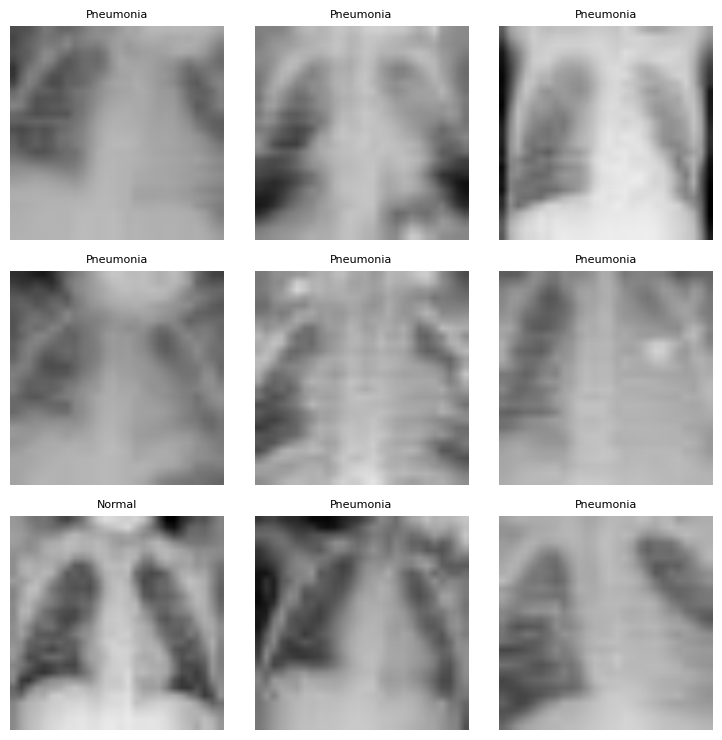

In [10]:
from torchvision.transforms.functional import to_pil_image

rows=3
cols=3
num_images = rows * cols
indices = random.sample(range(len(train_dataset)), num_images)

plt.figure(figsize=(cols * 2.5, rows * 2.5))

for i, idx in enumerate(indices):
    image, label = train_dataset[idx]
    img_np = np.array(to_pil_image(image))

    full_class_name = train_dataset.classes[label]
    clipped_name = full_class_name.split('.')[0]

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img_np)
    plt.title(clipped_name, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
class CNN_ViT_Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Load pretrained MobileNetV2
        pretrained_model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
        num_blocks1 = len(pretrained_model.features)

        # Freeze first half of MobileNetV2 efficiently
        for param in pretrained_model.features[:num_blocks1 // 2].parameters():
            param.requires_grad = False

        # Split MobileNetV2 into blocks
        self.mobilenet_feature_blocks_1 = nn.Sequential(*pretrained_model.features[:num_blocks1 - 3])
        self.mobilenet_block_2nd_last = pretrained_model.features[num_blocks1 - 3]
        self.mobilenet_block_mid = pretrained_model.features[num_blocks1 - 2]
        self.mobilenet_block_last = pretrained_model.features[num_blocks1 - 1]

        # Output channel sizes
        ch_2nd_last = self.mobilenet_block_2nd_last.out_channels # 160
        ch_last = self.mobilenet_block_last.out_channels # 1280
        ch_mid = self.mobilenet_block_mid.out_channels # 320
        ch_concat = ch_last + ch_2nd_last # 1440

        # CNN to ViT adapter
        adapter_layers = [
            nn.Conv2d(ch_mid, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Upsample(size=(14, 14), mode="bilinear", align_corners=False),
            nn.Conv2d(64, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Upsample(size=(28, 28), mode="bilinear", align_corners=False),
            nn.Conv2d(32, 16, kernel_size=3, padding=1), nn.BatchNorm2d(16), nn.GELU(), #Relu
            nn.Upsample(size=(56, 56), mode="bilinear", align_corners=False),
        ]

        self.cnn_to_vit_adapter = nn.Sequential(*adapter_layers)

        # Initialize ViT encoder for 56×56 feature maps
        # Vit - 2 - stride variation
        self.vit_encoder1 = VisionTransformer(
            img_size=56,
            patch_size=8,
            in_chans=16,
            num_classes=0,
            embed_dim=64,
            depth=2,
            num_heads=4,
            mlp_ratio=2,
            qkv_bias=True,
            norm_layer=nn.LayerNorm,
        )
        self.vit_encoder1.head = nn.Identity()  # return features, not logits


        # Enable overlapping patches by changing patch projection stride
        old_proj = self.vit_encoder1.patch_embed.proj
        self.vit_encoder1.patch_embed.proj = nn.Conv2d(
            old_proj.in_channels,
            old_proj.out_channels,
            kernel_size=8,
            stride=4,
            bias=old_proj.bias is not None,
        )


        # Infer number of patches produced by the new stride
        img_h, img_w = self.vit_encoder1.patch_embed.img_size
        dummy = torch.zeros(1, old_proj.in_channels, img_h, img_w)

        with torch.no_grad():
            _, _, h, w = self.vit_encoder1.patch_embed.proj(dummy).shape

        num_patches = h * w
        self.vit_encoder1.patch_embed.num_patches = num_patches


        # Reset positional embeddings to match new token count
        self.vit_encoder1.pos_embed = nn.Parameter(
            torch.zeros(1, num_patches + 1, self.vit_encoder1.embed_dim)
        )
        nn.init.trunc_normal_(self.vit_encoder1.pos_embed, std=0.02)

        # Vit - 1 - No stride variation
        self.vit_encoder2 = VisionTransformer(
            img_size=28, patch_size=7, in_chans=32,
            num_classes=0, embed_dim=64,
            depth=2, num_heads=4, mlp_ratio=2,
            qkv_bias=True, norm_layer=nn.LayerNorm,
        )
        self.vit_encoder2.head = nn.Identity()

        # CNN parallel head (from features_last only)
        self.cnn_parallel_head = nn.Sequential(
            nn.Conv2d(ch_concat, 128, kernel_size=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=0), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1), nn.Flatten(),
        )
        '''
        # 6) Parallel on 4th-last features
        self.parallel2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=ch_mid,
                out_channels=ch_mid,
                kernel_size=3, stride=1, padding=0
            ),
            MaxAvgPool2d(pool_size=(3,3), stride=(1,1)),
            nn.Conv2d(ch_mid * 2, 64, 3, padding=0), nn.BatchNorm2d(64), nn.GELU(),
            nn.Conv2d(64, 8, 3, padding=0), nn.BatchNorm2d(8), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1), nn.Flatten(),
        )
        '''
        # Final classifier
        self.classifier_head = nn.Linear(64 + 64 + 128, num_classes)

    def forward(self, x):
        features_1 = self.mobilenet_feature_blocks_1(x)
        features_2nd_last = self.mobilenet_block_2nd_last(features_1)
        features_mid = self.mobilenet_block_mid(features_2nd_last)
        features_last = self.mobilenet_block_last(features_mid)

        # Always resize to match before concat
        concatenated_cnn_features = torch.cat([features_last, features_2nd_last], dim=1)

        x = features_mid
        intermediate = None

        for i, layer in enumerate(self.cnn_to_vit_adapter):
            x = layer(x)

            # capture second-last stage (before last 4 layers)
            if i == len(self.cnn_to_vit_adapter) - 5:
                intermediate = x

        vit_input1 = x                 # full adapter output
        vit_input2 = intermediate      # derived from vit_input1 path

        vit_features1 = self.vit_encoder1(vit_input1) # 64
        vit_features2 = self.vit_encoder2(vit_input2) # 32

        # CNN parallel branch from final MobileNet block
        cnn_features = self.cnn_parallel_head(concatenated_cnn_features) # 96
        # cnn_features_2 = self.parallel2(features_mid)   # [B, 64]

        # Concatenate and classify
        combined = torch.cat([vit_features1, vit_features2, cnn_features], dim=1)
        return self.classifier_head(combined)

In [12]:
model = CNN_ViT_Model(num_classes=4)
summary(model, input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"])

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 110MB/s]


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
CNN_ViT_Model                                      [1, 3, 224, 224]          [1, 4]                    --                        Partial
├─Sequential: 1-1                                  [1, 3, 224, 224]          [1, 160, 7, 7]            --                        Partial
│    └─Conv2dNormActivation: 2-1                   [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d: 3-1                            [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d: 3-2                       [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─ReLU6: 3-3                             [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─InvertedResidual: 2-2                      

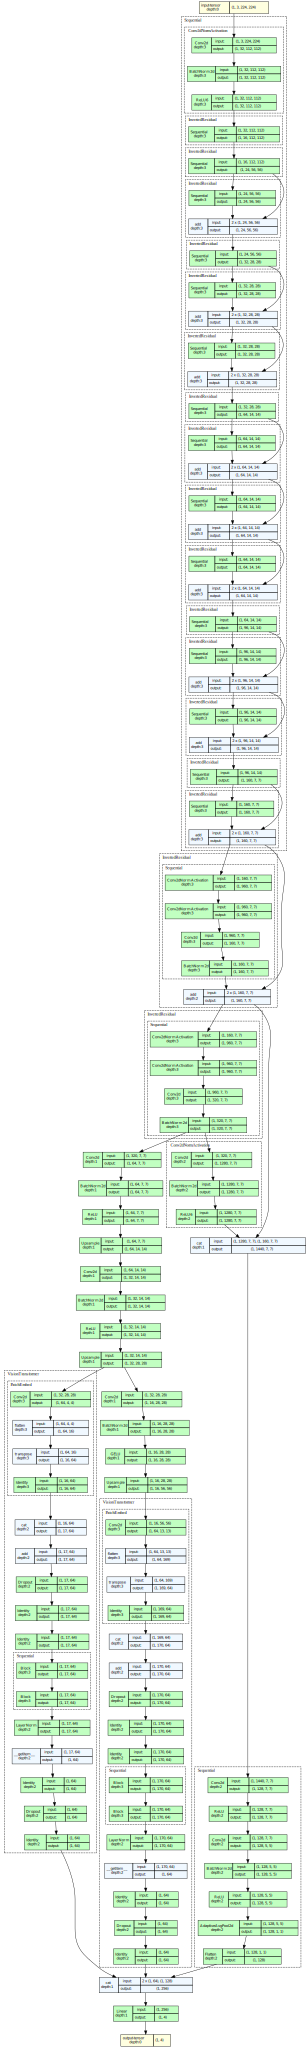

In [13]:
model.to(device)

# Dummy input (can adjust shape based on your model's expected input)
dummy_input = torch.randn(1, 3, 224, 224, device=device)

# Generate the graph — expand_nested=True if model has nested submodules
model_graph = draw_graph(
    model,
    input_data=dummy_input,
    expand_nested=True,
    graph_name="CNN_ViT_Model",
    save_graph=False  # We don't want to save, only display inline
)

# Render to SVG and display inline in the notebook
svg_output = model_graph.visual_graph.pipe(format='svg')
display(SVG(svg_output))

In [14]:
def custom_metrics(y_pred, y_true, loss):
    y_pred_classes = torch.argmax(y_pred, dim=1)

    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)

    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)

    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)

    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()

    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0.0
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0.0

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    num_classes = y_pred.shape[1]
    auc_scores = []

    for class_idx in range(num_classes):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()

        # Skip AUC if only one class is present
        if np.unique(class_y_true).size < 2:
            continue
        try:
            auc_score = roc_auc_score(class_y_true, class_y_pred)
            auc_scores.append(auc_score)
        except ValueError:
            continue

    auc_avg = np.mean(auc_scores) if auc_scores else 0.0

    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [15]:
# Hyperparameters
num_epochs       = EPOCHS
initial_lr       = 1e-4
decay_start_epoch = 10
decay_factor     = 0.97

# Criterion, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# Scheduler policy: 1.0 until epoch 11, then 0.98^(epoch - 11)
lr_lambda = lambda epoch: 1.0 if epoch < decay_start_epoch else decay_factor ** (epoch - decay_start_epoch)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

In [16]:
# Metrics initialization
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric: [] for metric in metric_names}
val_metrics_history = {metric: [] for metric in metric_names}

total_training_time = 0.0
total_validation_time = 0.0

# Training and validation loop
for epoch in range(num_epochs):
    start_time = time.time()

    # Training loop
    model.train()
    total_train_loss = 0.0
    all_train_predictions = []
    all_train_targets = []

    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Training Epoch [{epoch + 1}/{num_epochs}]")):
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        all_train_predictions.extend(outputs.detach().cpu().numpy())
        all_train_targets.extend(targets.detach().cpu().numpy())

    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time

    average_train_loss = total_train_loss / len(train_loader)
    all_train_predictions = np.array(all_train_predictions)
    all_train_targets = np.array(all_train_targets)

    train_metrics = custom_metrics(torch.tensor(all_train_predictions), torch.tensor(all_train_targets), average_train_loss)
    training_metrics_line = "Train Metrics - " + ", ".join([f"{k}: {v:.4f}" for k, v in train_metrics.items()])
    print(training_metrics_line)

    for metric in metric_names:
        train_metrics_history[metric].append(train_metrics[metric])

    # Validation loop
    model.eval()
    total_val_loss = 0.0
    all_val_predictions = []
    all_val_targets = []
    start_val_time = time.time()

    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader, desc="Validating Model")):
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)
            total_val_loss += loss.item()

            all_val_predictions.extend(outputs.detach().cpu().numpy())
            all_val_targets.extend(targets.detach().cpu().numpy())

    end_val_time = time.time()
    epoch_validation_time = end_val_time - start_val_time
    total_validation_time += epoch_validation_time

    average_val_loss = total_val_loss / len(val_loader)
    all_val_predictions = np.array(all_val_predictions)
    all_val_targets = np.array(all_val_targets)

    val_metrics = custom_metrics(torch.tensor(all_val_predictions), torch.tensor(all_val_targets), average_val_loss)
    validation_metrics_line = "Val Metrics - " + ", ".join([f"{k}: {v:.4f}" for k, v in val_metrics.items()])
    print(validation_metrics_line)

    for metric in metric_names:
        val_metrics_history[metric].append(val_metrics[metric])

    # Update LR via scheduler rather than manual mutliplication
    scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch}/{num_epochs} — Loss: {loss.item():.4f} — LR: {current_lr:.6f}")

print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

avg_training_time_per_epoch = total_training_time / (epoch + 1)
avg_validation_time_per_epoch = total_validation_time / (epoch + 1)
print(f"Average Training Time per Epoch: {str(timedelta(seconds=avg_training_time_per_epoch))}")
print(f"Average Validation Time per Epoch: {str(timedelta(seconds=avg_validation_time_per_epoch))}")

Training Epoch [1/25]:   0%|          | 0/486 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:659: UserWarning: pin_memory_device is deprecated, the current accelerator will be used as the device,ignore pin_memory_device='cuda'.
  warnings.warn(
/tmp/ipython-input-2352843275.py:34: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(img.astype(np.uint8), mode='L')
/tmp/ipython-input-2352843275.py:34: DeprecationWarning: 'mode' parame

Train Metrics - loss: 0.1640, accuracy: 0.9377, precision: 0.9354, recall: 0.9377, f1_score: 0.9355, specificity: 0.5954, sensitivity: 0.9780, mcc: 0.6269, auc: 0.9471


Validating Model:   0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:659: UserWarning: pin_memory_device is deprecated, the current accelerator will be used as the device,ignore pin_memory_device='cuda'.
  warnings.warn(
/tmp/ipython-input-2352843275.py:34: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(img.astype(np.uint8), mode='L')
/tmp/ipython-input-2352843275.py:34: DeprecationWarning: 'mode' parameter is

Val Metrics - loss: 0.1317, accuracy: 0.9447, precision: 0.9443, recall: 0.9447, f1_score: 0.9437, specificity: 0.8444, sensitivity: 0.9794, mcc: 0.8525, auc: 0.9883
Epoch 0/25 — Loss: 0.0491 — LR: 0.000100


Training Epoch [2/25]: 100%|██████████| 486/486 [00:17<00:00, 27.76it/s]


Train Metrics - loss: 0.0764, accuracy: 0.9740, precision: 0.9733, recall: 0.9740, f1_score: 0.9735, specificity: 0.8299, sensitivity: 0.9900, mcc: 0.8510, auc: 0.9889


Validating Model: 100%|██████████| 66/66 [00:02<00:00, 31.85it/s]


Val Metrics - loss: 0.1120, accuracy: 0.9637, precision: 0.9636, recall: 0.9637, f1_score: 0.9634, specificity: 0.9037, sensitivity: 0.9846, mcc: 0.9041, auc: 0.9909
Epoch 1/25 — Loss: 0.0045 — LR: 0.000100


Training Epoch [3/25]: 100%|██████████| 486/486 [00:17<00:00, 28.27it/s]


Train Metrics - loss: 0.0471, accuracy: 0.9827, precision: 0.9826, recall: 0.9827, f1_score: 0.9827, specificity: 0.9021, sensitivity: 0.9917, mcc: 0.9031, auc: 0.9960


Validating Model: 100%|██████████| 66/66 [00:01<00:00, 54.45it/s]


Val Metrics - loss: 0.0968, accuracy: 0.9656, precision: 0.9655, recall: 0.9656, f1_score: 0.9655, specificity: 0.9185, sensitivity: 0.9820, mcc: 0.9095, auc: 0.9920
Epoch 2/25 — Loss: 0.0171 — LR: 0.000100


Training Epoch [4/25]: 100%|██████████| 486/486 [00:17<00:00, 27.40it/s]


Train Metrics - loss: 0.0241, accuracy: 0.9925, precision: 0.9925, recall: 0.9925, f1_score: 0.9925, specificity: 0.9588, sensitivity: 0.9963, mcc: 0.9583, auc: 0.9991


Validating Model: 100%|██████████| 66/66 [00:01<00:00, 37.35it/s]


Val Metrics - loss: 0.1459, accuracy: 0.9504, precision: 0.9504, recall: 0.9504, f1_score: 0.9495, specificity: 0.8519, sensitivity: 0.9846, mcc: 0.8680, auc: 0.9877
Epoch 3/25 — Loss: 0.0907 — LR: 0.000100


Training Epoch [5/25]: 100%|██████████| 486/486 [00:17<00:00, 27.88it/s]


Train Metrics - loss: 0.0273, accuracy: 0.9912, precision: 0.9912, recall: 0.9912, f1_score: 0.9912, specificity: 0.9381, sensitivity: 0.9971, mcc: 0.9507, auc: 0.9982


Validating Model: 100%|██████████| 66/66 [00:01<00:00, 51.21it/s]


Val Metrics - loss: 0.1179, accuracy: 0.9656, precision: 0.9657, recall: 0.9656, f1_score: 0.9652, specificity: 0.8963, sensitivity: 0.9897, mcc: 0.9092, auc: 0.9903
Epoch 4/25 — Loss: 0.0012 — LR: 0.000100


Training Epoch [6/25]: 100%|██████████| 486/486 [00:19<00:00, 24.70it/s]


Train Metrics - loss: 0.0186, accuracy: 0.9936, precision: 0.9935, recall: 0.9936, f1_score: 0.9935, specificity: 0.9639, sensitivity: 0.9969, mcc: 0.9641, auc: 0.9992


Validating Model: 100%|██████████| 66/66 [00:01<00:00, 53.96it/s]


Val Metrics - loss: 0.2358, accuracy: 0.9332, precision: 0.9387, recall: 0.9332, f1_score: 0.9297, specificity: 0.7407, sensitivity: 1.0000, mcc: 0.8244, auc: 0.9850
Epoch 5/25 — Loss: 0.1638 — LR: 0.000100


Training Epoch [7/25]: 100%|██████████| 486/486 [00:17<00:00, 27.98it/s]


Train Metrics - loss: 0.0148, accuracy: 0.9961, precision: 0.9961, recall: 0.9961, f1_score: 0.9961, specificity: 0.9768, sensitivity: 0.9983, mcc: 0.9785, auc: 0.9992


Validating Model: 100%|██████████| 66/66 [00:01<00:00, 52.73it/s]


Val Metrics - loss: 0.1532, accuracy: 0.9580, precision: 0.9578, recall: 0.9580, f1_score: 0.9576, specificity: 0.8889, sensitivity: 0.9820, mcc: 0.8888, auc: 0.9867
Epoch 6/25 — Loss: 0.0084 — LR: 0.000100


Training Epoch [8/25]: 100%|██████████| 486/486 [00:18<00:00, 26.42it/s]


Train Metrics - loss: 0.0122, accuracy: 0.9961, precision: 0.9961, recall: 0.9961, f1_score: 0.9961, specificity: 0.9768, sensitivity: 0.9983, mcc: 0.9785, auc: 0.9998


Validating Model: 100%|██████████| 66/66 [00:01<00:00, 51.67it/s]


Val Metrics - loss: 0.1172, accuracy: 0.9714, precision: 0.9712, recall: 0.9714, f1_score: 0.9713, specificity: 0.9333, sensitivity: 0.9846, mcc: 0.9247, auc: 0.9915
Epoch 7/25 — Loss: 0.0002 — LR: 0.000100


Training Epoch [9/25]: 100%|██████████| 486/486 [00:17<00:00, 27.95it/s]


Train Metrics - loss: 0.0119, accuracy: 0.9967, precision: 0.9966, recall: 0.9967, f1_score: 0.9966, specificity: 0.9768, sensitivity: 0.9989, mcc: 0.9813, auc: 0.9998


Validating Model: 100%|██████████| 66/66 [00:01<00:00, 53.88it/s]


Val Metrics - loss: 0.1642, accuracy: 0.9485, precision: 0.9510, recall: 0.9485, f1_score: 0.9466, specificity: 0.8074, sensitivity: 0.9974, mcc: 0.8643, auc: 0.9913
Epoch 8/25 — Loss: 0.0008 — LR: 0.000100


Training Epoch [10/25]: 100%|██████████| 486/486 [00:18<00:00, 26.43it/s]


Train Metrics - loss: 0.0129, accuracy: 0.9967, precision: 0.9967, recall: 0.9967, f1_score: 0.9967, specificity: 0.9845, sensitivity: 0.9980, mcc: 0.9814, auc: 0.9995


Validating Model: 100%|██████████| 66/66 [00:01<00:00, 54.30it/s]


Val Metrics - loss: 0.1954, accuracy: 0.9504, precision: 0.9527, recall: 0.9504, f1_score: 0.9487, specificity: 0.8148, sensitivity: 0.9974, mcc: 0.8693, auc: 0.9869
Epoch 9/25 — Loss: 0.0028 — LR: 0.000100


Training Epoch [11/25]: 100%|██████████| 486/486 [00:17<00:00, 27.64it/s]


Train Metrics - loss: 0.0067, accuracy: 0.9979, precision: 0.9979, recall: 0.9979, f1_score: 0.9979, specificity: 0.9871, sensitivity: 0.9991, mcc: 0.9885, auc: 0.9999


Validating Model: 100%|██████████| 66/66 [00:01<00:00, 40.30it/s]


Val Metrics - loss: 0.1523, accuracy: 0.9618, precision: 0.9623, recall: 0.9618, f1_score: 0.9611, specificity: 0.8741, sensitivity: 0.9923, mcc: 0.8991, auc: 0.9895
Epoch 10/25 — Loss: 0.0011 — LR: 0.000097


Training Epoch [12/25]: 100%|██████████| 486/486 [00:18<00:00, 26.96it/s]


Train Metrics - loss: 0.0099, accuracy: 0.9972, precision: 0.9972, recall: 0.9972, f1_score: 0.9972, specificity: 0.9845, sensitivity: 0.9986, mcc: 0.9842, auc: 0.9989


Validating Model: 100%|██████████| 66/66 [00:01<00:00, 54.06it/s]


Val Metrics - loss: 0.1902, accuracy: 0.9542, precision: 0.9544, recall: 0.9542, f1_score: 0.9534, specificity: 0.8593, sensitivity: 0.9871, mcc: 0.8784, auc: 0.9849
Epoch 11/25 — Loss: 0.0461 — LR: 0.000094


Training Epoch [13/25]: 100%|██████████| 486/486 [00:17<00:00, 27.50it/s]


Train Metrics - loss: 0.0107, accuracy: 0.9961, precision: 0.9961, recall: 0.9961, f1_score: 0.9961, specificity: 0.9794, sensitivity: 0.9980, mcc: 0.9785, auc: 0.9998


Validating Model: 100%|██████████| 66/66 [00:02<00:00, 32.57it/s]


Val Metrics - loss: 0.1477, accuracy: 0.9676, precision: 0.9678, recall: 0.9676, f1_score: 0.9671, specificity: 0.8963, sensitivity: 0.9923, mcc: 0.9143, auc: 0.9924
Epoch 12/25 — Loss: 0.0010 — LR: 0.000091


Training Epoch [14/25]: 100%|██████████| 486/486 [00:17<00:00, 27.85it/s]


Train Metrics - loss: 0.0084, accuracy: 0.9977, precision: 0.9977, recall: 0.9977, f1_score: 0.9977, specificity: 0.9845, sensitivity: 0.9991, mcc: 0.9871, auc: 0.9999


Validating Model: 100%|██████████| 66/66 [00:01<00:00, 52.55it/s]


Val Metrics - loss: 0.1427, accuracy: 0.9656, precision: 0.9657, recall: 0.9656, f1_score: 0.9652, specificity: 0.8963, sensitivity: 0.9897, mcc: 0.9092, auc: 0.9924
Epoch 13/25 — Loss: 0.0069 — LR: 0.000089


Training Epoch [15/25]: 100%|██████████| 486/486 [00:18<00:00, 26.79it/s]


Train Metrics - loss: 0.0063, accuracy: 0.9972, precision: 0.9972, recall: 0.9972, f1_score: 0.9972, specificity: 0.9845, sensitivity: 0.9986, mcc: 0.9842, auc: 0.9999


Validating Model: 100%|██████████| 66/66 [00:01<00:00, 45.76it/s]


Val Metrics - loss: 0.1669, accuracy: 0.9676, precision: 0.9674, recall: 0.9676, f1_score: 0.9674, specificity: 0.9185, sensitivity: 0.9846, mcc: 0.9144, auc: 0.9879
Epoch 14/25 — Loss: 0.0016 — LR: 0.000086


Training Epoch [16/25]: 100%|██████████| 486/486 [00:17<00:00, 27.60it/s]


Train Metrics - loss: 0.0059, accuracy: 0.9982, precision: 0.9982, recall: 0.9982, f1_score: 0.9982, specificity: 0.9923, sensitivity: 0.9989, mcc: 0.9900, auc: 0.9999


Validating Model: 100%|██████████| 66/66 [00:01<00:00, 53.09it/s]


Val Metrics - loss: 0.2132, accuracy: 0.9580, precision: 0.9587, recall: 0.9580, f1_score: 0.9571, specificity: 0.8593, sensitivity: 0.9923, mcc: 0.8889, auc: 0.9901
Epoch 15/25 — Loss: 0.0012 — LR: 0.000083


Training Epoch [17/25]: 100%|██████████| 486/486 [00:18<00:00, 26.47it/s]


Train Metrics - loss: 0.0055, accuracy: 0.9979, precision: 0.9979, recall: 0.9979, f1_score: 0.9979, specificity: 0.9897, sensitivity: 0.9989, mcc: 0.9885, auc: 0.9999


Validating Model: 100%|██████████| 66/66 [00:01<00:00, 52.77it/s]


Val Metrics - loss: 0.1332, accuracy: 0.9771, precision: 0.9771, recall: 0.9771, f1_score: 0.9769, specificity: 0.9333, sensitivity: 0.9923, mcc: 0.9397, auc: 0.9952
Epoch 16/25 — Loss: 0.0004 — LR: 0.000081


Training Epoch [18/25]: 100%|██████████| 486/486 [00:17<00:00, 27.58it/s]


Train Metrics - loss: 0.0022, accuracy: 0.9997, precision: 0.9997, recall: 0.9997, f1_score: 0.9997, specificity: 0.9974, sensitivity: 1.0000, mcc: 0.9986, auc: 0.9999


Validating Model: 100%|██████████| 66/66 [00:01<00:00, 53.59it/s]


Val Metrics - loss: 0.1916, accuracy: 0.9580, precision: 0.9583, recall: 0.9580, f1_score: 0.9581, specificity: 0.9259, sensitivity: 0.9692, mcc: 0.8908, auc: 0.9885
Epoch 17/25 — Loss: 0.0003 — LR: 0.000078


Training Epoch [19/25]: 100%|██████████| 486/486 [00:18<00:00, 26.56it/s]


Train Metrics - loss: 0.0071, accuracy: 0.9977, precision: 0.9977, recall: 0.9977, f1_score: 0.9977, specificity: 0.9897, sensitivity: 0.9986, mcc: 0.9871, auc: 0.9999


Validating Model: 100%|██████████| 66/66 [00:01<00:00, 53.24it/s]


Val Metrics - loss: 0.1551, accuracy: 0.9599, precision: 0.9598, recall: 0.9599, f1_score: 0.9595, specificity: 0.8889, sensitivity: 0.9846, mcc: 0.8938, auc: 0.9936
Epoch 18/25 — Loss: 0.0011 — LR: 0.000076


Training Epoch [20/25]: 100%|██████████| 486/486 [00:17<00:00, 27.85it/s]


Train Metrics - loss: 0.0044, accuracy: 0.9985, precision: 0.9985, recall: 0.9985, f1_score: 0.9985, specificity: 0.9897, sensitivity: 0.9994, mcc: 0.9914, auc: 1.0000


Validating Model: 100%|██████████| 66/66 [00:01<00:00, 52.05it/s]


Val Metrics - loss: 0.1208, accuracy: 0.9656, precision: 0.9658, recall: 0.9656, f1_score: 0.9657, specificity: 0.9407, sensitivity: 0.9743, mcc: 0.9107, auc: 0.9933
Epoch 19/25 — Loss: 0.0005 — LR: 0.000074


Training Epoch [21/25]: 100%|██████████| 486/486 [00:18<00:00, 26.48it/s]


Train Metrics - loss: 0.0073, accuracy: 0.9972, precision: 0.9972, recall: 0.9972, f1_score: 0.9972, specificity: 0.9820, sensitivity: 0.9989, mcc: 0.9842, auc: 0.9999


Validating Model: 100%|██████████| 66/66 [00:01<00:00, 53.54it/s]


Val Metrics - loss: 0.1215, accuracy: 0.9714, precision: 0.9713, recall: 0.9714, f1_score: 0.9711, specificity: 0.9185, sensitivity: 0.9897, mcc: 0.9245, auc: 0.9931
Epoch 20/25 — Loss: 0.0005 — LR: 0.000072


Training Epoch [22/25]: 100%|██████████| 486/486 [00:17<00:00, 27.69it/s]


Train Metrics - loss: 0.0041, accuracy: 0.9987, precision: 0.9987, recall: 0.9987, f1_score: 0.9987, specificity: 0.9897, sensitivity: 0.9997, mcc: 0.9928, auc: 0.9999


Validating Model: 100%|██████████| 66/66 [00:01<00:00, 36.12it/s]


Val Metrics - loss: 0.1737, accuracy: 0.9599, precision: 0.9598, recall: 0.9599, f1_score: 0.9595, specificity: 0.8889, sensitivity: 0.9846, mcc: 0.8938, auc: 0.9887
Epoch 21/25 — Loss: 0.0014 — LR: 0.000069


Training Epoch [23/25]: 100%|██████████| 486/486 [00:18<00:00, 26.99it/s]


Train Metrics - loss: 0.0014, accuracy: 0.9995, precision: 0.9995, recall: 0.9995, f1_score: 0.9995, specificity: 0.9974, sensitivity: 0.9997, mcc: 0.9971, auc: 1.0000


Validating Model: 100%|██████████| 66/66 [00:01<00:00, 53.32it/s]


Val Metrics - loss: 0.1484, accuracy: 0.9656, precision: 0.9661, recall: 0.9656, f1_score: 0.9658, specificity: 0.9481, sensitivity: 0.9717, mcc: 0.9112, auc: 0.9925
Epoch 22/25 — Loss: 0.0002 — LR: 0.000067


Training Epoch [24/25]: 100%|██████████| 486/486 [00:17<00:00, 27.23it/s]


Train Metrics - loss: 0.0008, accuracy: 0.9997, precision: 0.9997, recall: 0.9997, f1_score: 0.9997, specificity: 1.0000, sensitivity: 0.9997, mcc: 0.9986, auc: 1.0000


Validating Model: 100%|██████████| 66/66 [00:01<00:00, 37.61it/s]


Val Metrics - loss: 0.1419, accuracy: 0.9695, precision: 0.9693, recall: 0.9695, f1_score: 0.9692, specificity: 0.9185, sensitivity: 0.9871, mcc: 0.9194, auc: 0.9911
Epoch 23/25 — Loss: 0.0002 — LR: 0.000065


Training Epoch [25/25]: 100%|██████████| 486/486 [00:17<00:00, 27.73it/s]


Train Metrics - loss: 0.0001, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1_score: 1.0000, specificity: 1.0000, sensitivity: 1.0000, mcc: 1.0000, auc: 1.0000


Validating Model: 100%|██████████| 66/66 [00:01<00:00, 53.59it/s]

Val Metrics - loss: 0.1569, accuracy: 0.9714, precision: 0.9717, recall: 0.9714, f1_score: 0.9710, specificity: 0.9037, sensitivity: 0.9949, mcc: 0.9246, auc: 0.9911
Epoch 24/25 — Loss: 0.0002 — LR: 0.000063
Total Training Time: 0:07:37.594821
Total Validation Time: 0:00:35.096262
Average Training Time per Epoch: 0:00:18.303793
Average Validation Time per Epoch: 0:00:01.403850


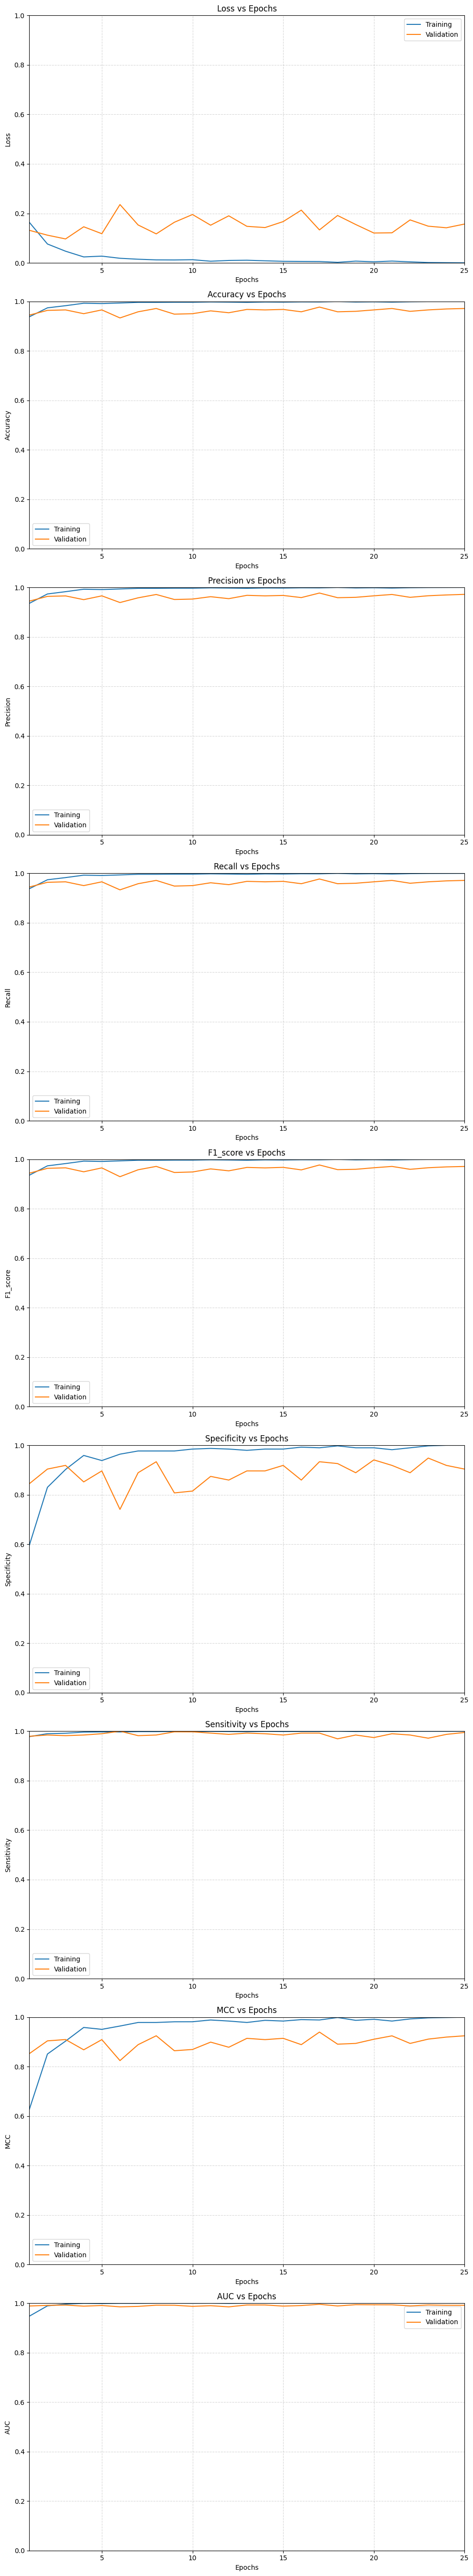

In [17]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))
    rng = range(1, num_epochs + 1)

    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]

        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(f"{metric_name.upper()} vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(f"{metric_name.capitalize()} vs Epochs")

        max_metric = max(max(train_metric), max(val_metric))
        min_metric = min(min(train_metric), min(val_metric))
        y_max = math.ceil(max_metric)

        if min_metric > 0 or max_metric > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_metric, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        # Adjust xlim to avoid identical low and high limits.
        if num_epochs == 1:
            ax.set_xlim(0.5, 1.5)
        else:
            ax.set_xlim(1, num_epochs)

    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

In [18]:
# Testing loop
model.eval()
total_test_loss = 0.0
all_test_predictions = []
all_test_targets = []

with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_test_loss += loss.item()

        all_test_predictions.extend(outputs.detach().cpu().numpy())
        all_test_targets.extend(targets.detach().cpu().numpy())

all_test_predictions = np.array(all_test_predictions)
all_test_targets = np.array(all_test_targets)

average_test_loss = total_test_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_test_predictions), torch.tensor(all_test_targets), average_test_loss)
testing_metrics_line = "Test Metrics - " + ", ".join([f"{k}: {v:.4f}" for k, v in test_metrics.items()])
print(testing_metrics_line)

Testing Model:   0%|          | 0/78 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:659: UserWarning: pin_memory_device is deprecated, the current accelerator will be used as the device,ignore pin_memory_device='cuda'.
  warnings.warn(
/tmp/ipython-input-2352843275.py:34: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(img.astype(np.uint8), mode='L')
/tmp/ipython-input-2352843275.py:34: DeprecationWarning: 'mode' parameter is de

Test Metrics - loss: 1.0224, accuracy: 0.8253, precision: 0.8591, recall: 0.8253, f1_score: 0.8104, specificity: 0.5427, sensitivity: 0.9949, mcc: 0.6427, auc: 0.9615


In [19]:
# Convert true_labels and predicted_labels to numpy arrays
true_labels = np.array(all_test_targets)

# Assuming predicted_labels are probabilities, convert them to class labels
predicted_labels = np.argmax(np.array(all_test_predictions), axis=1)

# Ensure both true_labels and predicted_labels are of integer type
true_labels = true_labels.astype(int)
predicted_labels = predicted_labels.astype(int)

# Get a list of subdirectories (class names) in the data directory
# Option 1: sort the list
# classes = sorted([d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))])

# # Option 2: if using ImageFolder
# classes = full_train_dataset.classes
classes = train_dataset.classes

# classes = label_encoder.classes_

# Generate a classification report
report = classification_report(true_labels, predicted_labels, target_names=classes, digits=4)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)

print(report)
print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

              precision    recall  f1-score   support

      Normal     0.9845    0.5427    0.6997       234
   Pneumonia     0.7838    0.9949    0.8768       390

    accuracy                         0.8253       624
   macro avg     0.8842    0.7688    0.7883       624
weighted avg     0.8591    0.8253    0.8104       624

There were 109 errors in 624 tests for an accuracy of  82.53
